In [182]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
from scipy import optimize
import time
import functools
from multiprocessing import Pool
#from cyipopt import minimize_ipopt
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore")

random.seed(10)


In [183]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare/eq_price_new"
# = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare/eq_price_ch3"

In [184]:
data = pd.read_csv(os.path.join(input_dir,r"welfare_eq_result_update_baseline_ch3.csv"))

In [185]:
list(data.columns)

['level_0',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_

Text(0.5, 1.0, 'Actual prices vs. Status Quo Equiligirum Prices')

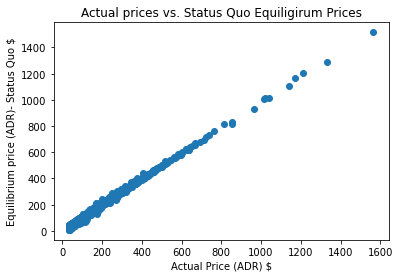

In [186]:
plt.scatter(data["ADR"],data["price_ne"])
plt.xlabel("Actual Price (ADR) $")
plt.ylabel("Equilibrium price (ADR)- Status Quo $")
plt.title("Actual prices vs. Status Quo Equiligirum Prices")

In [187]:
data[["ADR","price_ne"]].describe()

,ADR,price_ne
count,5597.000000,5597.000000
mean,141.570217,141.918005
std,96.118163,95.217815
min,34.083241,7.304442
25%,85.236818,85.532135
50%,119.546934,120.224608
75%,170.744239,170.809152
max,1563.839872,1516.132598


In [188]:


alpha = -0.012
sigma = 0.5396
rating_param_chain = 0.075-0.016
rating_param_ind = 0.075

occ_upper= 88

In [189]:
miami = data[data["Market"]=="Miami/Hialeah, FL"]

In [190]:
(miami["market_share_ne"]-miami["market_share_cf"]).describe()

count    734.000000
mean       0.000017
std        0.004771
min       -0.043162
25%       -0.000824
50%       -0.000075
75%        0.000606
max        0.032691
dtype: float64

# Calculate marginal cost and total cost

In [191]:
# Status Quo marginal cost

#data["occ_ne"] = (data["demand_ne"]*100/30)/data["capacity"]

data_lower = data[data["demand_ne"]<=data["q_upper"]]

data_upper = data[data["demand_ne"]>data["q_upper"]]

data_lower["excess_demand"] = 0
data_lower["cost_ne"] = (192.39814102368837+data_lower["hotel_fixed_effect"]+data_lower["market_time_fixed_effect"])*\
                           data_lower["demand_ne"]
data_upper["excess_demand"] = data_upper["demand_ne"]-data_upper["q_upper"]
data_upper["cost_ne"] = (192.39814102368837+data_upper["hotel_fixed_effect"]+data_upper["market_time_fixed_effect"])*\
                           data_upper["q_upper"]+0.5*0.043841100663268406*(data_upper["excess_demand"]**2)


data= pd.concat([data_lower,data_upper],axis=0)

data = data.fillna(0)



In [192]:



data_lower = data[data["demand_cf"]<=data["q_upper"]]
data_upper = data[data["demand_cf"]>data["q_upper"]]

data_lower["excess_demand"] = 0
data_lower["cost_cf"] = (192.39814102368837+data_lower["hotel_fixed_effect"]+data_lower["market_time_fixed_effect"])*\
                           data_lower["demand_cf"]
data_upper["excess_demand"] = data_upper["demand_cf"]-data_upper["q_upper"]
data_upper["cost_cf"] = (192.39814102368837+data_upper["hotel_fixed_effect"]+data_upper["market_time_fixed_effect"])*\
                           data_upper["q_upper"]+0.5*0.043841100663268406*(data_upper["excess_demand"]**2)

data = pd.concat([data_lower,data_upper],axis=0)



# Calculate Consumer Surplus

In [193]:
data["r_greater_exante"] = data["exante_rating"]<data["Rating"]

#df["market_share_percent_diff"] = (df["market_share_cf"] - df["market_share"])/df["market_share"]


In [194]:
# calculate walfare

    
data_chain = data[data["operation"]=='Chain_affiliated'].reset_index().drop(["index"],axis=1)
data_ind = data[data["operation"]=='Independent'].reset_index().drop(["index"],axis=1)

data_chain["market_share_cf_delta_diff"] = data_chain["market_share_cf"]*(rating_param_chain*(data_chain["Rating"] - data_chain["exante_rating"])+alpha*(data_chain["price_ne"]-data_chain["price_cf"]))
data_ind["market_share_cf_delta_diff"] = data_ind["market_share_cf"]*(rating_param_ind*(data_ind["Rating"] - data_ind["exante_rating"])+alpha*(data_ind["price_ne"]-data_ind["price_cf"]))
 
    
data = pd.concat([data_chain, data_ind],axis=0).reset_index().drop(["index"],axis=1)
    
l=[]
for i in (0,1,2):
    
    df_temp = data[data["Market"]==data["Market"].unique()[i]]
    diff = df_temp.groupby(["month","year"])["market_share_cf_delta_diff"].sum().reset_index().rename(columns={"market_share_cf_delta_diff":"diff_term"})
    temp = df_temp.merge(diff,on=["month","year"], how="left")
    l.append(temp)
    
df = pd.concat(l,axis=0)


In [195]:
df_cs = df[["Market","year","month","Market Monthly Supply","D_g_sum_ne","D_g_sum_cf","diff_term","market_size"]].drop_duplicates()

df_cs["cs"] = (np.log(1+df_cs["D_g_sum_ne"]) - np.log(1+df_cs["D_g_sum_cf"])-df_cs["diff_term"])/alpha


In [196]:
df_cs["month_cs"] = df_cs["cs"]*df_cs["market_size"]

cs_result = df_cs.groupby("Market")["month_cs"].sum()/1000000
cs_result = cs_result.reset_index("Market")
cs_result.transpose()


,0,1,2
Market,"Chicago, IL","Houston, TX","Miami/Hialeah, FL"
month_cs,-2.429544,-4.658473,-4.702643


# Calculate Revenue, Profit, Marginal Cost

In [197]:
df = data

In [198]:
df["Revenue_cf"] = df["market_share_cf"]*df["market_size"]*df["price_cf"]
df["Revenue_ne"] = df["market_share_ne"]*df["market_size"]*df["price_ne"]
df["revenue_diff"] = df["Revenue_cf"] - df["Revenue_ne"]
df.groupby("Market")["revenue_diff"].sum()/1000000

Market
Chicago, IL           6.324924
Houston, TX          11.080796
Miami/Hialeah, FL   -32.008186
Name: revenue_diff, dtype: float64

In [199]:
#miami = df[df["Market"]=="Miami/Hialeah, FL"]
df["price_diff"] = df["price_cf"]-df["price_ne"]
df["market_share_diff"] = df["market_share_cf"]-df["market_share_ne"]

In [200]:
df.groupby(["Market","r_greater_exante"])["revenue_diff"].mean()

Market             r_greater_exante
Chicago, IL        False               21274.454038
                   True               -17123.906320
Houston, TX        False                9554.066707
                   True                -6806.755799
Miami/Hialeah, FL  False              -35253.988647
                   True               -59586.361324
Name: revenue_diff, dtype: float64

In [201]:
df.groupby(["Market","r_greater_exante"])["market_share_diff"].mean()*100

Market             r_greater_exante
Chicago, IL        False               0.007201
                   True               -0.010609
Houston, TX        False               0.003103
                   True               -0.007528
Miami/Hialeah, FL  False              -0.010727
                   True                0.015568
Name: market_share_diff, dtype: float64

In [202]:
df.groupby(["Market"])["market_share_diff"].describe()

,count,mean,std,min,25%,50%,75%,max
Market,,,,,,,,
"Chicago, IL",1364.0,-0.000005,0.000762,-0.008057,-0.000109,0.000017,0.000172,0.005164
"Houston, TX",3499.0,-0.000010,0.000444,-0.005132,-0.000090,-0.000005,0.000066,0.004404
"Miami/Hialeah, FL",734.0,-0.000017,0.004771,-0.032691,-0.000606,0.000075,0.000824,0.043162


In [203]:
df.groupby(["Market"])["price_diff"].describe()

,count,mean,std,min,25%,50%,75%,max
Market,,,,,,,,
"Chicago, IL",1364.0,0.404525,5.163495,-40.139272,-0.640805,-0.012491,1.140347,46.026339
"Houston, TX",3499.0,1.264811,5.039737,-42.508798,-0.626376,1.109420,2.813192,48.990902
"Miami/Hialeah, FL",734.0,0.526315,10.959932,-45.925124,-3.604913,-0.228103,3.674253,73.589986


In [204]:
df.groupby(["Market","r_greater_exante"]).size()

Market             r_greater_exante
Chicago, IL        False                773
                   True                 591
Houston, TX        False               2133
                   True                1366
Miami/Hialeah, FL  False                482
                   True                 252
dtype: int64

In [205]:
df["revenue_diff"].sum()/1000000

-14.602465381055685

In [206]:


df.groupby(["r_greater_exante"])["revenue_diff"].sum()/1000000
                                        

r_greater_exante
False    19.831555
True    -34.434020
Name: revenue_diff, dtype: float64

In [207]:
df["ps_cf"] = df["Revenue_cf"]-df["cost_cf"]
df["ps_ne"] = df["Revenue_ne"]-df["cost_ne"]
df["ps_diff"] = df["ps_cf"] - df["ps_ne"]
df.groupby("Market")["ps_diff"].sum()/1000000

Market
Chicago, IL          -4.813694
Houston, TX          12.027355
Miami/Hialeah, FL   -27.969254
Name: ps_diff, dtype: float64

In [208]:
df["ps_diff"].sum()/1000000

-20.75559364807471

In [209]:
df.groupby(["r_greater_exante"])["ps_diff"].sum()/1000000

r_greater_exante
False    11.194527
True    -31.950121
Name: ps_diff, dtype: float64

In [210]:
df["cost_diff"] = df["cost_cf"] - df["cost_ne"]
df["cost_diff"].sum()/1000000


6.153128267019037

In [211]:
df.groupby(["r_greater_exante"])["cost_diff"].sum()/1000000

r_greater_exante
False    8.637028
True    -2.483899
Name: cost_diff, dtype: float64

In [212]:
df.groupby("Market")["cost_diff"].sum()/1000000

Market
Chicago, IL          11.138619
Houston, TX          -0.946559
Miami/Hialeah, FL    -4.038931
Name: cost_diff, dtype: float64

In [213]:
df["market_share_sum_diff"] = df["market_share_sum_cf"] - df["market_share_sum_ne"]

total_market_share = df[["Market","year","month","market_share_sum_diff","market_size"]].drop_duplicates()

total_market_share["market_share_sum_diff"].mean()*100

-0.15597745121660594

In [214]:

total_market_share.groupby("Market")["market_share_sum_diff"].mean()*100

Market
Chicago, IL         -0.058629
Houston, TX         -0.305346
Miami/Hialeah, FL   -0.103957
Name: market_share_sum_diff, dtype: float64

In [215]:
df.groupby("operation")["ps_diff"].sum()/1000000

operation
Chain_affiliated     5.841941
Independent        -26.597534
Name: ps_diff, dtype: float64

In [216]:
df.groupby(["r_greater_exante","operation"])["ps_diff"].sum()/1000000

r_greater_exante  operation       
False             Chain_affiliated    17.246853
                  Independent         -6.052326
True              Chain_affiliated   -11.404912
                  Independent        -20.545209
Name: ps_diff, dtype: float64

In [217]:
df.groupby("operation")["revenue_diff"].sum()/1000000

operation
Chain_affiliated    20.377873
Independent        -34.980338
Name: revenue_diff, dtype: float64

In [218]:
df.groupby(["r_greater_exante","operation"])["revenue_diff"].sum()/1000000

r_greater_exante  operation       
False             Chain_affiliated    41.460305
                  Independent        -21.628750
True              Chain_affiliated   -21.082432
                  Independent        -13.351588
Name: revenue_diff, dtype: float64

In [219]:
df.groupby("operation")["cost_diff"].sum()/1000000

operation
Chain_affiliated    14.535932
Independent         -8.382804
Name: cost_diff, dtype: float64

In [220]:
df.groupby(["r_greater_exante","operation"])["cost_diff"].sum()/1000000

r_greater_exante  operation       
False             Chain_affiliated    24.213452
                  Independent        -15.576425
True              Chain_affiliated    -9.677520
                  Independent          7.193621
Name: cost_diff, dtype: float64

In [221]:
df.groupby(["operation","r_greater_exante"]).size()

operation         r_greater_exante
Chain_affiliated  False               2939
                  True                1889
Independent       False                449
                  True                 320
dtype: int64

In [222]:
df.groupby(["r_greater_exante"]).size()

r_greater_exante
False    3388
True     2209
dtype: int64

In [223]:
list(df.columns)

['level_0',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_

In [224]:
total_market_share = df.groupby(["operation","year","month"])["market_share_ne"].sum().reset_index().rename(columns={"market_share_ne":"market_share_sum"})
total_market_share_cf = df.groupby(["operation","year","month"])["market_share_cf"].sum().reset_index().rename(columns={"market_share_cf":"market_share_sum_cf"})

df_3 = df.merge(total_market_share, on=["operation","year","month"]).merge(total_market_share_cf, on=["operation","year","month"])

df_3["market_share_sum_diff"] = df_3["market_share_sum_cf_y"] - df_3["market_share_sum"]

total_market_share = df_3[["operation","year","month","market_share_sum_diff","market_size"]].drop_duplicates()

        

In [225]:
total_market_share.groupby("operation")["market_share_sum_diff"].mean()*100

operation
Chain_affiliated    0.352339
Independent        -0.820271
Name: market_share_sum_diff, dtype: float64

In [181]:
df_3

,level_0,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,revenue_diff,price_diff,market_share_diff,ps_cf,ps_ne,ps_diff,cost_diff,market_share_sum_diff,market_share_sum,market_share_sum_cf_y
0,1,2016-01,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,...,-42739.605791,2.043685,-0.000131,43696.911316,38464.722516,5232.188800,-47971.794591,0.009272,1.325468,1.33474
1,3,2016-01,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,...,621265.688669,-29.486814,0.001833,-99838.774617,9730.393344,-109569.167960,730834.856629,0.009272,1.325468,1.33474
2,4,2016-01,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,...,-498005.409580,12.838272,-0.002561,252568.576309,207771.090169,44797.486140,-542802.895720,0.009272,1.325468,1.33474
3,5,2016-01,108548,2016-01-01,12400.0,5208.0,713046.00,42.0000,136.913594,57.503710,...,18713.881768,-1.890109,0.000161,46961.262255,53764.638024,-6803.375769,25517.257537,0.009272,1.325468,1.33474
4,6,2016-01,117817,2016-01-01,9796.0,4682.0,1214459.00,47.7950,259.388936,123.974990,...,765503.386444,-26.255290,0.002925,-202143.602305,-7134.680962,-195008.921344,960512.307788,0.009272,1.325468,1.33474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,5537,2016-12,84172,2016-12-01,2809.0,2453.0,287065.00,87.3264,117.026091,102.194731,...,-83121.546081,14.394817,-0.003830,-14632.221761,2096.114544,-16728.336305,-66393.209776,-0.015868,0.432108,0.41624
5593,5544,2016-12,81425,2016-12-01,1395.0,1194.0,184907.00,85.5913,154.863484,132.549821,...,6628.387594,1.009220,0.000105,-42137.724342,-48606.610345,6468.886003,159.501591,-0.015868,0.432108,0.41624
5594,5577,2016-12,740551,2016-12-01,1984.0,1928.0,273603.00,97.1774,141.910270,137.904738,...,-28744.793896,6.549600,-0.001032,63607.929187,79971.025301,-16363.096114,-12381.697783,-0.015868,0.432108,0.41624
5595,5580,2016-12,86353,2016-12-01,6756.0,5442.0,1299259.00,80.5506,238.746601,192.311871,...,-714248.207249,19.757487,-0.012352,94882.000806,194301.625520,-99419.624715,-614828.582535,-0.015868,0.432108,0.41624
